# Validation for National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook validates National Intertidal Digital Elevation Model (NIDEM) data against multiple validation datasets (RTK GPS, 5m LIDAR DEM data and multibeam). 

**Date:** January 2019

**Author:** Robbi Bishop-Taylor

In [1]:
# Import libraries
import sys
import os
import glob
import fiona
import scipy
import rasterio
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import statsmodels.formula.api as sm
from shapely.geometry import Point
from pyproj import Proj, transform
from osgeo import gdal
from scipy import stats
from scipy import ndimage as nd
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import mean_squared_error

# Set working directory
os.chdir('/g/data/r78/rt1527/nidem')


def plot_kde(x, y, ax=None, nbins=300, y_lims=(-5, 5), x_lims=(-5, 5), cmap='viridis', power=1.0, mask_by_density=0.0):
    
    """
    Plots set of paired x and y values as a kernel density plot 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    :attr nbins: number of x/y axis bins used to compute kernel density (default: 300)
    :attr y_lims: y-axis limits for plot (default: (-5, 5))
    :attr x_lims: x-axis limits for plot (default: (-5, 5))
    :attr power: optionally allows you to stretch the resulting kernel density values by raising
                 by a power prior to plotting. Values below 1 visually enhance low density areas
    """

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = stats.kde.gaussian_kde([x, y])
    xi, yi = np.mgrid[y_lims[0]:y_lims[1]:nbins*1j, x_lims[0]:x_lims[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    zi = np.power(zi, power) 
    
    # Reshape array into 2d and optionally mask out density values lower than mask_by_density
    density_array = zi.reshape(xi.shape)
    density_array[density_array < mask_by_density] = np.nan     
    

    # Plot output x-y scatter plot
    if ax:
        
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cmap)
        ax.set_ylim(y_lims[0], y_lims[1])
        ax.set_xlim(x_lims[0], x_lims[1])
    
    else:
    
        fig, ax = plt.subplots(figsize = (12, 12))        
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cmap)
        ax.set_ylim(y_lims[0], y_lims[1])
        ax.set_xlim(x_lims[0], x_lims[1])
    
    return density_array


def RMSE(x, y):
    
    """
    Computes root mean squared error (RMSE) from two lists of observed and modelled values. 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    
    :returns: float of computed RMSE 
    """
    
    return ((y - x) ** 2).mean() ** 0.5


%load_ext autoreload
%autoreload 2


## LiDAR validation
Lidar 5m DEM source: https://data.gov.au/dataset/digital-elevation-model-dem-of-australia-derived-from-lidar-5-metre-grid

In [2]:
# Dict of study areas and to process; contains matching ITEM polygon and MGA zone for each LIDAR dataset
study_areas_df = pd.read_csv('lidar_study_areas.csv', index_col=0)
study_areas = study_areas_df.to_dict('index')

# List to append results for each area into
out_list = list()

for name in study_areas: 
# for name in ['Ulverstone']: 
  
    # Use MGA zone from file
    mga_zone = study_areas[name]['mga_zone']
    lidar_raster = study_areas[name]['lidar_raster']
    intertidal_type = study_areas[name]['type']
    x_tl, y_tl = study_areas[name]['bbox_ul'].split(',')
    x_br, y_br = study_areas[name]['bbox_br'].split(',')

    # Clip NIDEM to study area extent
    nidem_vrt_path = 'output_data/geotiff/nidem/NIDEM.vrt'
    nidem_subset_path = f'scratch/validation_data/lidar_dems/nidem_subset_{name}.tif'
    !gdalwarp -te $x_tl $y_br $x_br $y_tl -te_srs epsg:4326 -overwrite $nidem_vrt_path $nidem_subset_path
    
    with rasterio.open(nidem_subset_path) as nidem_ds:
        nidem_profile = nidem_ds.profile
        nidem_array = nidem_ds.read(1, masked=True)
        nidem_transform = nidem_ds.transform
        
    # Clip Lidar DEM to study area extent
    lidar_subset_path = f'scratch/validation_data/lidar_dems/lidar_subset_{name}.tif'
    !gdalwarp -te $x_tl $y_br $x_br $y_tl -te_srs epsg:4326 -t_srs epsg:3577 -tr 25 25 -dstnodata -9999 -r average -overwrite $lidar_raster $lidar_subset_path
    
    with rasterio.open(lidar_subset_path) as lidar_ds:
        lidar_array = lidar_ds.read(1, masked=True)        
    
    # Test if tidal tagging is required for area
    if not pd.isnull(study_areas[name]['input_loc']):  
    
        # Import data
        points_df = pd.read_csv('output_data/validation/output_points_{}.csv'.format(name))   
        
        # Convert lat-lon points to X and Y Australian Albers coords
        x, y = transform(p1=Proj(init='EPSG:4326'), p2=Proj(init="EPSG:3577"),
                         x=points_df['point_lon'].values, y=points_df['point_lat'].values)
        
        # Covert inds
        x_ind, y_ind = ~nidem_transform * (x, y)
        point_ind = pd.DataFrame(np.around(np.column_stack([x_ind, y_ind])), 
                                 columns=['x_ind','y_ind']).astype(np.int16)
        point_ind = point_ind[point_ind['x_ind'].between(0, nidem_array.shape[1], inclusive = False)]
        point_ind = point_ind[point_ind['y_ind'].between(0, nidem_array.shape[0], inclusive = False)]

        # Create mask of areas with exposed non-water LIDAR points
        mask_unfiltered = np.full(nidem_array.shape, False) 
        mask_unfiltered[point_ind.y_ind, point_ind.x_ind] = True

        # Clean mask using morphological opening and closing
        mask = nd.binary_opening(mask_unfiltered)
        mask = nd.binary_closing(mask)
        
        # Export mask
        nidem_profile.update(dtype = rasterio.int16)
        with rasterio.open(f'scratch/validation_data/lidar_dems/lidar_mask_{name}.tif', 'w', **nidem_profile) as dst:
            dst.write(mask.astype(rasterio.int16), 1)

        # Extract LIDAR and NIDEM elevation dat
        lidar_df = pd.DataFrame({'site': name,                                  
                                 'intertidal_type': intertidal_type,
                                 'validation_type': 'lidar',
                                 'validation_elev': lidar_array[mask], 
                                 'nidem_elev': nidem_array[mask]}).dropna()
    
    # If tidal masking is not required, compare rasters like-for-like
    else:
        
        # Extract LIDAR and NIDEM elevation data
        lidar_df = pd.DataFrame({'site': name, 
                                 'intertidal_type': intertidal_type,
                                 'validation_type': 'lidar',
                                 'validation_elev': lidar_array.flatten(), 
                                 'nidem_elev': nidem_array.flatten()}).dropna() 

    # Append resulting dataframe to file
    out_list.append(lidar_df) 

# Combine into single dataframe
lidar_df = pd.concat(out_list) 


Creating output file that is 517P x 267L.
Processing input file output_data/geotiff/nidem/NIDEM.vrt.
Using internal nodata values (e.g. -9999) for image output_data/geotiff/nidem/NIDEM.vrt.
Copying nodata values from source output_data/geotiff/nidem/NIDEM.vrt to destination scratch/validation_data/lidar_dems/nidem_subset_Whitsunday.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 517P x 267L.
Processing input file raw_data/validation/LIDAR_dems/QLD/z55/qldz55.tif.
Using internal nodata values (e.g. -3.40282e+38) for image raw_data/validation/LIDAR_dems/QLD/z55/qldz55.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 303P x 166L.
Processing input file output_data/geotiff/nidem/NIDEM.vrt.
Using internal nodata values (e.g. -9999) for image output_data/geotiff/nidem/NIDEM.vrt.
Copying nodata values from source output_data/geotiff/nidem/NIDEM.vrt to destination scratch/validation_data/lidar_dems/nide

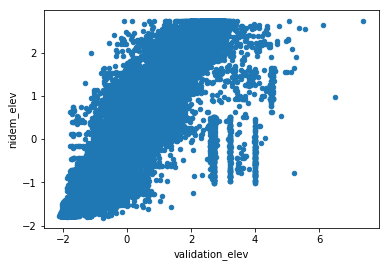

In [3]:
lidar_df.plot.scatter(x='validation_elev', y='nidem_elev')

## GPS validation

In [4]:
# Combine individual GPS survey lines
dataframeslist = []
for i in glob.glob('raw_data/validation/thomson_validation/THOMSON2018*.shp'):    
    single_gdf = gpd.read_file(i, encoding="utf-8")
    single_gdf['survey'] = i[39:-4]
    dataframeslist.append(single_gdf)

thomson_gdf = gpd.GeoDataFrame(pd.concat(dataframeslist, ignore_index=True), crs=dataframeslist[0].crs).to_crs(epsg='3577')
thomson_gdf.to_file('raw_data/validation/thomson_validation/thomson_combined_albers.shp')
             

In [5]:
# Datasets to iterate over
gps_shapefiles = {'Darwin': {'path': 'raw_data/validation/EastPointonlyRTK_albers.shp', 
                             'elev_col': 'field_4', 'intertidal_type': 'tidal_flat'},
#                  'Thomson': {'path': 'raw_data/validation/thomson_validation/thomson_combined_albers.shp', 
#                              'elev_col': 'Elev_AHD', 'intertidal_type': 'sandy_beach'},
                  'Moreton_Bay': {'path': 'raw_data/validation/danaher_brisbane_albers.shp', 
                                  'elev_col': 'Elevatio_1', 'intertidal_type': 'tidal_flat'}}

# List to append results for each area into
out_list = list()

for name in gps_shapefiles:
# for name in ['brisbane']:
    
    # Read shapefile data
    gps_gdf = gpd.read_file(gps_shapefiles[name]['path'])
    gps_gdf = gps_gdf[[gps_shapefiles[name]['elev_col'], 'geometry']]
    gps_gdf.columns = ['validation_elev', 'geometry']
    
    # Save in consistent format
    gps_gdf.to_file('gps_points.shp')
    
    # Get bounding box for raster extract
    x_tl, y_tl, x_br, y_br = gps_gdf.to_crs(epsg='4326').buffer(0.03).total_bounds 
    print(f'{name}, {x_tl:.5f} E {-y_tl:.5f} S, {x_br:.5f} E {-y_br:.5f} S')
    
    # Clip NIDEM vrt layer to bounds of shapefile
    nidem_vrt_path = 'output_data/geotiff/nidem/NIDEM.vrt'
    nidem_subset_path = f'scratch/validation_data/gps_dems/nidem_subset_{name}.tif'
    !gdalwarp -te $x_tl $y_tl $x_br $y_br -te_srs epsg:4326 -overwrite $nidem_vrt_path $nidem_subset_path
        
    # Load clipped layer as array, and copy extent, resolution, transform
    with rasterio.open(nidem_subset_path) as nidem_ds:
        nidem_profile = nidem_ds.profile
        nidem_transform = nidem_ds.transform
        
        x_tl, y_tl, x_br, y_br = nidem_ds.bounds
        nidem_xres = nidem_transform[0]
        nidem_yres = nidem_transform[4]
        
        nidem_array = nidem_ds.read(1, masked=True)
    
    # Workaround for rasterising finely-spaced GPS points into a comparable 25m raster: rasterise GPS points 
    # first into a very high resolution 1m DEM, then aggregate this in gdalwarp using 'average' resampling to 
    # compute the average GPS value within each NIDEM 25m pixel.
    !gdal_rasterize -at -tr 1 1 -init -9999 -a_nodata -9999 -a 'validation' -a_srs epsg:3577 gps_points.shp scratch/validation_data/gps_dems/gps_dem_1m.tif
    !gdalwarp -te $x_tl $y_tl $x_br $y_br -te_srs epsg:3577 -t_srs epsg:3577 -tr $nidem_xres $nidem_yres -srcnodata -9999 -r average -overwrite scratch/validation_data/gps_dems/gps_dem_1m.tif scratch/validation_data/gps_dems/gps_dem_25m.tif

    # Load resulting 25m GPS layer as an array
    with rasterio.open('scratch/validation_data/gps_dems/gps_dem_25m.tif') as gps_ds:
        gps_profile = gps_ds.profile
        gps_array = gps_ds.read(1, masked=True)        
   
    # Extract LIDAR and NIDEM elevation data for pixels which have data in both datasets
    gps_df = pd.DataFrame({'site': name, 
                           'intertidal_type': gps_shapefiles[name]['intertidal_type'],
                           'validation_type': 'rtk_gps',
                           'validation_elev': gps_array[(gps_array.mask == False) & (nidem_array.mask == False)], 
                           'nidem_elev': nidem_array[(gps_array.mask == False) & (nidem_array.mask == False)]}).dropna()
    
    # Append resulting dataframe to file
    out_list.append(gps_df) 

# # Combine into single dataframe
gps_df = pd.concat(out_list)     
    

Darwin, 130.78231 E 12.43566 S, 130.85607 E 12.37220 S
Creating output file that is 324P x 279L.
Processing input file output_data/geotiff/nidem/NIDEM.vrt.
Using internal nodata values (e.g. -9999) for image output_data/geotiff/nidem/NIDEM.vrt.
Copying nodata values from source output_data/geotiff/nidem/NIDEM.vrt to destination scratch/validation_data/gps_dems/nidem_subset_Darwin.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 324P x 279L.
Processing input file scratch/validation_data/gps_dems/gps_dem_1m.tif.
Copying nodata values from source scratch/validation_data/gps_dems/gps_dem_1m.tif to destination scratch/validation_data/gps_dems/gps_dem_25m.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Moreton_Bay, 153.03747 E 27.51057 S, 153.23696 E 27.27759 S
Creating output file that is 941P x 903L.
Processing input file output_data/geotiff/nidem/NIDEM.vrt.
Using in

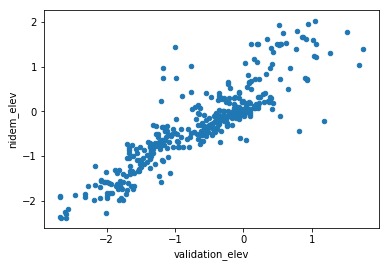

In [6]:
gps_df.plot.scatter(x='validation_elev', y='nidem_elev')

## Multibeam validations

In [7]:
# Paths to multibeam datasets
multibeam_paths = glob.glob("raw_data/validation/WAMSI_KimberlyReefs/*.tif")

# List to append results for each area into
out_list = list()

# for path in multibeam_paths:
for multibeam_path in multibeam_paths:
    
    # Extract name from string
    name = multibeam_path[40:-7]
    
    # Get extent from multibeam raster
    with rasterio.open(multibeam_path) as multibeam_ds:
        multibeam_profile = multibeam_ds.profile
        x_tl, y_br, x_br, y_tl = multibeam_ds.bounds
        print(f'{name}, {x_tl:.5f} E {-y_tl:.5f} S, {x_br:.5f} E {-y_br:.5f} S')
        
    # Clip NIDEM to study area extent
    nidem_vrt_path = 'output_data/geotiff/nidem/NIDEM.vrt'
    nidem_subset_path = f'scratch/validation_data/multibeam_dems/nidem_subset_{name}.tif'
    !gdalwarp -te $x_tl $y_br $x_br $y_tl -te_srs epsg:4326 -overwrite $nidem_vrt_path $nidem_subset_path
        
    with rasterio.open(nidem_subset_path) as nidem_ds:
        nidem_profile = nidem_ds.profile
        nidem_array = nidem_ds.read(1, masked=True)
        nidem_transform = nidem_ds.transform
        
    # Clip Lidar DEM to study area extent
    multibeam_subset_path = f'scratch/validation_data/multibeam_dems/multibeam_subset_{name}.tif'
    !gdalwarp -te $x_tl $y_br $x_br $y_tl -te_srs epsg:4326 -t_srs epsg:3577 -tr 25 25 -srcnodata -9999 -r average -overwrite $multibeam_path $multibeam_subset_path

    with rasterio.open(multibeam_subset_path) as multibeam_ds:
        multibeam_array = multibeam_ds.read(1, masked=True) 
        
    # Extract LIDAR and NIDEM elevation data
    multibeam_df = pd.DataFrame({'site': name, 
                             'intertidal_type': 'rocky_reef',
                             'validation_type': 'multibeam',
                             'validation_elev': multibeam_array.flatten(), 
                             'nidem_elev': nidem_array.flatten()}).dropna() 

    # Append resulting dataframe to file
    out_list.append(multibeam_df) 

# Combine into single dataframe
multibeam_df = pd.concat(out_list)   


Cockatoo_Island, 123.59018 E 16.08976 S, 123.60608 E 16.10020 S
Creating output file that is 65P x 50L.
Processing input file output_data/geotiff/nidem/NIDEM.vrt.
Using internal nodata values (e.g. -9999) for image output_data/geotiff/nidem/NIDEM.vrt.
Copying nodata values from source output_data/geotiff/nidem/NIDEM.vrt to destination scratch/validation_data/multibeam_dems/nidem_subset_Cockatoo_Island.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 65P x 50L.
Processing input file raw_data/validation/WAMSI_KimberlyReefs/Cockatoo_Island_1m.tif.
Copying nodata values from source raw_data/validation/WAMSI_KimberlyReefs/Cockatoo_Island_1m.tif to destination scratch/validation_data/multibeam_dems/multibeam_subset_Cockatoo_Island.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Tallon_west, 123.11392 E 16.40050 S, 123.12354 E 16.41947 S
Creating output file that is 35P x 86L.
Processing input file output_data/geotiff/nidem/NIDEM

## Plotting and analysis

In [8]:
all_validations = pd.concat([lidar_df, gps_df, multibeam_df])

### Site correlations

In [9]:
site_count_df = all_validations.groupby(['site', 'intertidal_type', 'validation_type']).count().iloc[:,1].to_frame(name='N')
site_spearman_df = all_validations.groupby(['site', 'intertidal_type', 'validation_type']).corr(method='spearman').iloc[::2,1].to_frame(name='Spearman correlation').round(2).reset_index(level=3, drop=True)
site_pearson_df = all_validations.groupby(['site', 'intertidal_type', 'validation_type']).corr(method='pearson').iloc[::2,1].to_frame(name='Pearson correlation').round(2).reset_index(level=3, drop=True)
site_rmse_df = all_validations.groupby(['site', 'intertidal_type', 'validation_type']).apply(lambda x: mean_squared_error(x.validation_elev, x.nidem_elev)**0.5).to_frame(name='RMSE').round(2)


In [10]:
# site_count_df
site_count_df['Spearman correlation'] = site_spearman_df
site_count_df['Pearson correlation'] = site_pearson_df
site_count_df['RMSE'] = site_rmse_df
site_df = site_count_df.reset_index()

site_df['intertidal_type'] = pd.Categorical(site_df['intertidal_type'], ["sandy_beach", 'tidal_flat', 'rocky_reef'])
site_df.sort_values(['intertidal_type', 'validation_type', 'N'], ascending=[1, 1, 0])

,site,intertidal_type,validation_type,N,Spearman correlation,Pearson correlation,RMSE
12,Robbins,sandy_beach,lidar,39688,0.67,0.78,0.57
6,Isaac,sandy_beach,lidar,33756,0.98,0.97,0.29
9,Mackay,sandy_beach,lidar,31863,0.96,0.94,0.34
19,WesternPort,sandy_beach,lidar,8341,0.92,0.91,0.18
13,Rockhampton,sandy_beach,lidar,8077,0.96,0.95,0.33
14,SAcoastal,tidal_flat,lidar,31267,0.69,0.38,0.50
4,Fraser,tidal_flat,lidar,20553,0.76,0.81,0.31
11,NormantonToKaurumba,tidal_flat,lidar,15217,0.92,0.88,0.27
20,Whitsunday,tidal_flat,lidar,13707,0.92,0.96,0.19
8,Launceston,tidal_flat,lidar,8029,0.87,0.88,0.33


### Individual correlations

In [11]:
spearman_df = all_validations.groupby(['intertidal_type', 'validation_type']).corr(method='spearman').iloc[::2,1].to_frame(name='Spearman correlation')
spearman_df.index = spearman_df.index.droplevel(2)
spearman_df

Spearman correlation
intertidal_type validation_type                      
rocky_reef      lidar                        0.785597
                multibeam                    0.747479
sandy_beach     lidar                        0.927913
tidal_flat      lidar                        0.806748
                rtk_gps                      0.897711

In [12]:
pearson_df = all_validations.groupby(['intertidal_type', 'validation_type']).corr(method='pearson').iloc[::2,1].to_frame(name='Pearson correlation')
pearson_df.index = pearson_df.index.droplevel(2)
pearson_df

Pearson correlation
intertidal_type validation_type                     
rocky_reef      lidar                       0.755497
                multibeam                   0.367583
sandy_beach     lidar                       0.923484
tidal_flat      lidar                       0.784200
                rtk_gps                     0.886601

In [13]:
rmse_df = all_validations.groupby(['intertidal_type', 'validation_type']).apply(lambda x: mean_squared_error(x.validation_elev, x.nidem_elev)**0.5).to_frame(name='RMSE')
rmse_df

RMSE
intertidal_type validation_type          
rocky_reef      lidar            0.520554
                multibeam        3.798896
sandy_beach     lidar            0.409754
tidal_flat      lidar            0.385718
                rtk_gps          0.526777

### Combined correlations

In [14]:
spearman_df = all_validations.groupby(['intertidal_type']).corr(method='spearman').iloc[::2,1].to_frame(name='Spearman correlation')
spearman_df.index = spearman_df.index.droplevel(1)
spearman_df

,Spearman correlation
intertidal_type,
rocky_reef,0.789548
sandy_beach,0.927913
tidal_flat,0.807034


In [15]:
pearson_df = all_validations.groupby(['intertidal_type']).corr(method='pearson').iloc[::2,1].to_frame(name='Pearson correlation')
pearson_df.index = pearson_df.index.droplevel(1)
pearson_df

,Pearson correlation
intertidal_type,
rocky_reef,0.463626
sandy_beach,0.923484
tidal_flat,0.784917


In [16]:
rmse_df = all_validations.groupby(['intertidal_type']).apply(lambda x: mean_squared_error(x.validation_elev, x.nidem_elev)**0.5).to_frame(name='RMSE')
rmse_df

,RMSE
intertidal_type,
rocky_reef,2.983354
sandy_beach,0.409754
tidal_flat,0.386395


### Plots

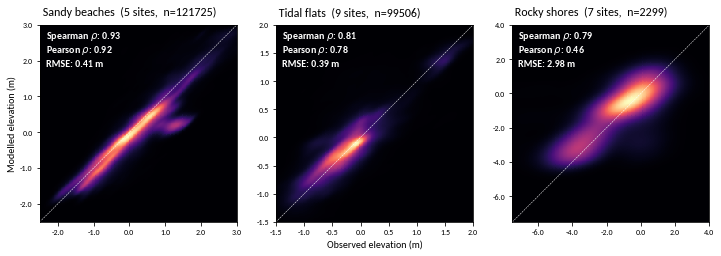

In [17]:
# Count data for each category
counts_df = all_validations.groupby(['intertidal_type']).count().iloc[:,0]
count_beach = counts_df.loc["sandy_beach"]
count_tidalflat = counts_df.loc["tidal_flat"]
count_reef = counts_df.loc["rocky_reef"]

# Sites for each category
n_df = all_validations.groupby(['intertidal_type']).site.nunique()
n_beach = n_df.loc["sandy_beach"]
n_tidalflat = n_df.loc["tidal_flat"]
n_reef = n_df.loc["rocky_reef"] 

# Set up plot with three square panels
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,3,1, adjustable='box', aspect=1)
ax2 = fig.add_subplot(1,3,2, adjustable='box', aspect=1)
ax3 = fig.add_subplot(1,3,3, adjustable='box', aspect=1)

# Plotting params
mask_by_density = 0.0
cmap = 'magma'
bg_colour = 'black' # '#262626'
nbins = 250
power = 0.8
beach_limits = (-2.5, 3)
tidalflat_limits = (-1.5, 2)
reef_limits = (-7.5, 4.0)

# Beach kernel density plot
plot_kde(x=all_validations[all_validations.intertidal_type == 'sandy_beach'].validation_elev, 
         y=all_validations[all_validations.intertidal_type == 'sandy_beach'].nidem_elev, 
         ax=ax1, nbins=nbins, cmap=cmap, power=power,
         mask_by_density=mask_by_density,
         x_lims=beach_limits, y_lims=beach_limits) 

ax1.plot(np.linspace(*beach_limits), np.linspace(*beach_limits), 'white', linestyle='dashed', linewidth=0.5)
ax1.set_title(f" Sandy beaches  ({n_beach} sites,  n={count_beach})", fontname='Carlito', loc='left', pad = 9)
ax1.tick_params(direction='out', labelsize=8)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.patch.set_facecolor(bg_colour)
ax1.set_xticklabels(ax1.get_xticks(), fontname='Carlito')
ax1.set_yticklabels(ax1.get_yticks(), fontname='Carlito')

# Tidal flats
plot_kde(x=all_validations[all_validations.intertidal_type == 'tidal_flat'].validation_elev, 
         y=all_validations[all_validations.intertidal_type == 'tidal_flat'].nidem_elev, 
         ax=ax2, nbins=nbins, cmap=cmap, power=power,
         mask_by_density=mask_by_density,         
         x_lims=tidalflat_limits, y_lims=tidalflat_limits) 

ax2.plot(np.linspace(*tidalflat_limits), np.linspace(*tidalflat_limits), 'white', linestyle='dashed', linewidth=0.5)
ax2.set_title(f" Tidal flats  ({n_tidalflat} sites,  n={count_tidalflat})", fontname='Carlito', loc='left', pad = 9)
ax2.tick_params(direction='out', labelsize=8)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.patch.set_facecolor(bg_colour)
ax2.set_xticklabels(ax2.get_xticks(), fontname='Carlito')
ax2.set_yticklabels(ax2.get_yticks(), fontname='Carlito')

# Reefs
plot_kde(x=all_validations[all_validations.intertidal_type == 'rocky_reef'].validation_elev, 
         y=all_validations[all_validations.intertidal_type == 'rocky_reef'].nidem_elev, 
         ax=ax3, nbins=nbins, cmap=cmap, power=power,
         mask_by_density=mask_by_density,
         x_lims=reef_limits, y_lims=reef_limits)

ax3.plot(np.linspace(*reef_limits), np.linspace(*reef_limits), 'white', linestyle='dashed', linewidth=0.5)

ax3.set_title(f" Rocky shores  ({n_reef} sites,  n={count_reef})", fontname='Carlito', loc='left', pad = 9)
ax3.tick_params(direction='out', labelsize=8)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.patch.set_facecolor(bg_colour)
ax3.set_xticklabels(ax3.get_xticks(), fontname='Carlito')
ax3.set_yticklabels(ax3.get_yticks(), fontname='Carlito') 

# Set main plot axis labels
ax1.set_ylabel('Modelled elevation (m)', fontname='Carlito')
ax2.set_xlabel('Observed elevation (m)', fontname='Carlito')

# Add annotations
ax1.annotate(r"Spearman $\rho$: {0:0.2f}".format(spearman_df.loc['sandy_beach'].item()), 
             xy=(0.03, 0.93), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax2.annotate(r"Spearman $\rho$: {0:0.2f}".format(spearman_df.loc['tidal_flat'].item()), 
             xy=(0.03, 0.93), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax3.annotate(r"Spearman $\rho$: {0:0.2f}".format(spearman_df.loc['rocky_reef'].item()), 
             xy=(0.03, 0.93), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')

ax1.annotate(r"Pearson $\rho$: {0:0.2f}".format(pearson_df.loc['sandy_beach'].item()), 
             xy=(0.03, 0.86), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax2.annotate(r"Pearson $\rho$: {0:0.2f}".format(pearson_df.loc['tidal_flat'].item()), 
             xy=(0.03, 0.86), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax3.annotate(r"Pearson $\rho$: {0:0.2f}".format(pearson_df.loc['rocky_reef'].item()), 
             xy=(0.03, 0.86), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')

ax1.annotate("RMSE: {0:0.2f} m".format(rmse_df.loc['sandy_beach'].item()), 
             xy=(0.03, 0.79), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax2.annotate("RMSE: {0:0.2f} m".format(rmse_df.loc['tidal_flat'].item()), 
             xy=(0.03, 0.79), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')
ax3.annotate("RMSE: {0:0.2f} m".format(rmse_df.loc['rocky_reef'].item()), 
             xy=(0.03, 0.79), xycoords='axes fraction', fontname='Carlito', color='white', fontweight='bold')

# Export
fig.savefig("figures/Validation_density/Revised_Figure6_validationdensity.png", pad_inches=0, dpi=600, bbox_inches='tight')
# ax1.set_title(f" Tidal range  ({n_beach} sites,  n={count_beach})", fontname='Carlito', loc='left', pad = 9)
# ax2.set_title(f" Landsat observations  ({n_beach} sites,  n={count_beach})", fontname='Carlito', loc='left', pad = 9)
# ax3.set_title(f" Low tide offset  ({n_reef} sites,  n={count_reef})", fontname='Carlito', loc='left', pad = 9)
# fig.savefig("figures/to_delete.png", pad_inches=0, dpi=230, bbox_inches='tight')

In [18]:
# kws = dict(s=10, alpha=0.2, linewidth=0, edgecolor="w")
# g = sns.FacetGrid(all_validations, col="intertidal_type", height=10, hue='validation_type', xlim=(-5, 5), ylim=(-5, 5))
# g = (g.map(sns.scatterplot, 'validation_elev', 'nidem_elev', **kws))

In [19]:
# sns.scatterplot(data=test, x='validation_elev', y='nidem_elev', hue='intertidal_type', size=0.01)
# sns.lmplot(data=all_validations, x='validation_elev', y='nidem_elev',hue='intertidal_type', 
#            height=10, aspect=1.0, scatter_kws={'alpha': 0.01})

In [20]:
# import os
# from osgeo import gdal

# os.chdir('/g/data/r78/Airborne_LIDAR/GulfofCarpentaria/')
# li_dirs= [folder for folder in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), folder))]
# li_dirs

# li_all_files = list()
# for folder in li_dirs:
#     path = os.path.join(os.getcwd(), folder)
#     li_files = [file for file in os.listdir(path) if os.path.splitext(file)[-1] == '.bil']
#     for file in li_files:
#         li_all_files.append(os.path.join(path, file))

# out = gdal.BuildVRT('/g/data/r78/Airborne_LIDAR/GulfofCarpentaria/GulfofCarpentaria.vrt', li_all_files)
# out = None

In [21]:
# !gdaladdo -ro --config COMPRESS_OVERVIEW DEFLATE -r AVERAGE -ro /g/data/r78/Airborne_LIDAR/GulfofCarpentaria/GulfofCarpentaria.vrt 64

In [22]:
out_list = {}

# List of polygons
validation_dems = sorted(glob.glob("/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_*.tif"))
validation_dems

# # For each NIDEM DEM, export .csv of min, max elevations and range
for i, dem in enumerate(validation_dems):
    
    slope_ds = gdal.DEMProcessing(destName='scratch/lidar_slope.tif', 
                                  srcDS=dem, 
                                  processing = 'slope',
                                  scale = 1)
    slope_array = slope_ds.GetRasterBand(1).ReadAsArray()  
    slope_array[slope_array == -9999.] = np.nan
    
    nidem_ds = gdal.Open(dem.replace('lidar_subset', 'nidem_subset'))
    nidem_array = np.array(nidem_ds.GetRasterBand(1).ReadAsArray())
    nidem_array = (nidem_array == -9999.).astype(bool)
    
    try:
        ds_mask = gdal.Open(dem.replace('subset', 'mask'))
        mask = np.array(ds_mask.GetRasterBand(1).ReadAsArray())
        mask = mask.astype(bool)

    except:
        mask = np.ones(slope_array.shape).astype(bool)
        
    slope_array[~mask] = np.nan
    slope_array[nidem_array] = np.nan
    
    slope_mean = np.nanmean(slope_array)
    slope_median = np.nanmedian(slope_array)
    out_list[dem] = slope_median
    
    
    slope_ds = None
    nidem_ds = None
    ds_mask = None

    
#     # open raster and choose band to find min, max
#     print('Importing {}'.format(dem))
#     gtif = gdal.Open(dem)
#     srcband = gtif.GetRasterBand(1)   
#     nidem_array = srcband.ReadAsArray()   

#     # Get raster statistics
#     stats = srcband.GetStatistics(True, True)    
    
#     # Get attributes
#     polygon = dem.split("_")[-1][:-4]
#     elev_min = stats[0]
#     elev_max = stats[1]
#     elev_range = elev_max - elev_min
#     intertidal_pixels = np.count_nonzero(nidem_array != -9999.)
#     intertidal_km2 = intertidal_pixels * (25 * 25) / (1000 * 1000)
    
#     if elev_range > 0:
    
#         # Compute slope
#         slope_ds = gdal.DEMProcessing(destName='scratch/nidem_slope.tif', 
#                                       srcDS=dem, 
#                                       processing = 'slope',
#                                       scale = 1)
#         slope_array = slope_ds.GetRasterBand(1).ReadAsArray()  
#         slope_array[slope_array == -9999.] = np.nan
#         slope_mean = np.nanmean(slope_array)
#         slope_median = np.nanmedian(slope_array)

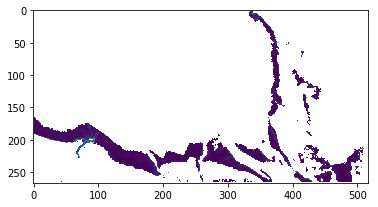

In [23]:
plt.imshow(slope_array)

In [24]:
out_list

{'/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Fraser.tif': 0.21956623,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Gladstone.tif': 0.1890599,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Isaac.tif': 0.17659448,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Kilcunda.tif': 0.77983737,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Launceston.tif': 0.4448694,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Mackay.tif': 0.14663994,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_NormantonToKaurumba.tif': 0.07656857,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Robbins.tif': 0.21113938,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_Rockhampton.tif': 0.27692217,
 '/g/data/r78/rt1527/nidem/scratch/validation_data/lidar_dems/lidar_subset_

## Compute areas of filtered vs unfiltered NIDEM

In [25]:
# output_dict = {}

# for polygon in range(1, 307):
    
    
#     poly_path = glob.glob(f'/g/data/fk4/datacube/002/NIDEM/netcdf/NIDEM_{polygon}_*.nc')[0]    
#     nidem_netcdf = xr.open_dataset(poly_path)

#     nidem_unfiltered_bool = xr.ufuncs.isfinite(nidem_netcdf.nidem_unfiltered)
#     nidem_mask_bool = xr.ufuncs.isfinite(nidem_netcdf.nidem_mask)
#     total_unfiltered = nidem_unfiltered_bool.sum().item()
#     total_filtered = (~nidem_mask_bool & nidem_unfiltered_bool).sum().item()
        
#     item_conf_rem = ((nidem_netcdf.nidem_mask == 3) & nidem_unfiltered_bool).sum().item()
#     shallow_rem = ((nidem_netcdf.nidem_mask == 1) & nidem_unfiltered_bool).sum().item()
#     deep_rem = ((nidem_netcdf.nidem_mask == 2) & nidem_unfiltered_bool).sum().item()
    
#     output_dict[polygon] = [total_unfiltered, total_filtered, item_conf_rem, shallow_rem, deep_rem]
    
#     print(output_dict[polygon])

In [26]:
# masked_df = pd.DataFrame(output_dict).T * ((25 * 25) / 1000000)
# masked_df.columns = ['unfiltered', 'filtered',  'confidence', 'terrestrial', 'subtidal']
# masked_df = masked_df
# masked_df.sum(axis=0)

In [27]:
# masked_df.sort_values('subtidal', ascending=False)